# MCT4001 Scientific Computing in Python Session 6
![mct-banner](https://raw.githubusercontent.com/wiki/MCT-master/Guides/assets/img/mct-banner.jpg)

This notebook (as well as those for session 8 to 11) does not introduce any new Python programming element (basides using a few new functions from scipy.signal and perhaps new types of matplotlib visualization). Instead we use Python and the scientific computing packages to learn about key concepts about audio signal processing. In particular we carry out experiments in which theoretical knowledge is verified through computation, visualization (i.e. plot the signals) and auralization (i.e. listen to the signals).

In [1]:
# enabling auto completion
%config IPCompleter.greedy=True

%matplotlib inline
#%matplotlib notebook

In [2]:
# importing packages

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time



# defining utility funtions that will be used in this notebook

# generate sine signal
def mySineSynth(freq, dur_ms, amp=1, pha=0, sr=48000):

    t = np.arange(0,dur_ms/1000,1/sr)
    s = amp*np.sin(2*np.pi*freq*t+pha)
    
    return s

# stem plot with specific xticks and ylim 
def myPlot(signal,title):
    plt.figure(figsize=(12, 3))
    plt.stem(signal, use_line_collection=True)
    plt.grid(True)
    plt.xticks(range(0,signal.size))
    plt.ylim([-1,1])
    plt.title(title)
    plt.show()

# stem plot
def myPlot2(signal,title):
    plt.figure(figsize=(12, 3))
    plt.stem(signal, use_line_collection=True)
    plt.grid(True)
    plt.title(title)
    plt.show()

# stem plot with specific range and xticks to display correlation result
def myPlotCorr(signal,lx,ly,title):
    plt.figure(figsize=(12, 3))
    plt.stem(range(-ly+1,lx),signal, use_line_collection=True)
    plt.grid(True)
    plt.xticks(range(-ly+1,lx))
    plt.title(title)
    plt.show()

# spectrogram using librosa
def mySpectrogram(s,sr,title):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(12, 3))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.show()

# spectrogram using scipy.signal
def mySpectrogram2(s,sr,title):
    f, t, S = scipy.signal.spectrogram(s, sr)
    SdB = 20*np.log10(S)
    plt.figure(figsize=(12, 3))
    plt.pcolormesh(t, f, SdB)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

# waveform uwing librosa
def myWaveform(s,sr,title):
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(s, sr=sr)
    plt.title(title)
    plt.show()

# compute and display the response of a FIR filter
def myFirResponse(h,sr):
    p, z = scipy.signal.freqz(h)
    p = (p/(2*math.pi))*sr
    fig = plt.figure(figsize=(12, 3))
    plt.title('Digital FIR filter frequency response')
    ax1 = fig.add_subplot(111)
    plt.plot(p, 20 * np.log10(abs(z)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [Hz')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(z))
    plt.plot(p, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')
    plt.grid()
    plt.axis('tight')
    plt.show()

## 1. Demistyfying Convolution

The output *y(n)* of a Finite Impulse Response (FIR) Linear and Time Invariat (LTI) system with impulrse response *h(n)* and with arbitrary input *x(n)* is computed convolving (i.e. computing the convolution) between *x(n)* and *h(n)*. To simplify the visualization of short signals we use the stem plot.

![LTI](https://www.wisdomjobs.com/userfiles/discrete_convolution.png)


The discrete convolution (for time discrete signals, such as digital audio) is defined as![Conv Formula](https://www.wisdomjobs.com/userfiles/convolution.png)


Where *x(n)* represents the signal, *h(n)* the impulse response of the system, and *y(n)* is the output (result of the convolution).

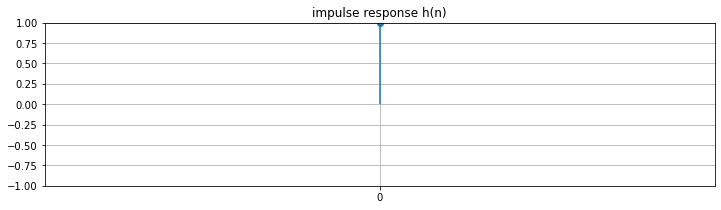

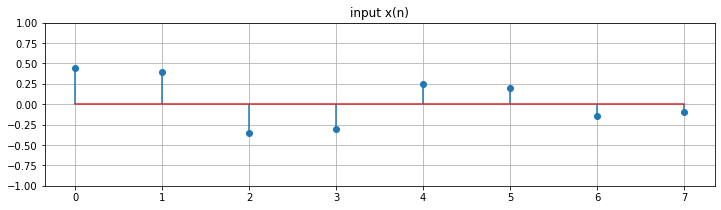

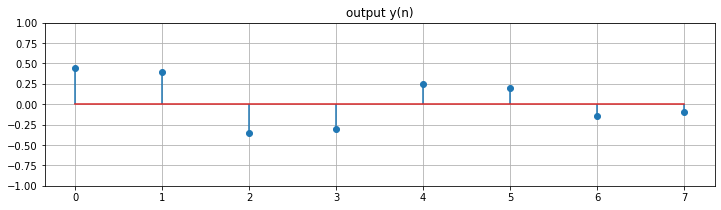

In [3]:
#convolution between a signal and an impulse

# inpulse response
h = np.zeros(1) 
h[0] = 1

# arbitrary input
x = np.array([0.45, 0.40, -0.35, -0.3, 0.25, 0.2, -0.15, -0.10])

# computing output via convolution
y = scipy.signal.convolve(x,h) #possible to use also np.convolve()

myPlot(h, 'impulse response h(n)')
myPlot(x, 'input x(n)')
myPlot(y, 'output y(n)')

### Experiment 1
changing the magnitude and sign (polarity of the impulse)

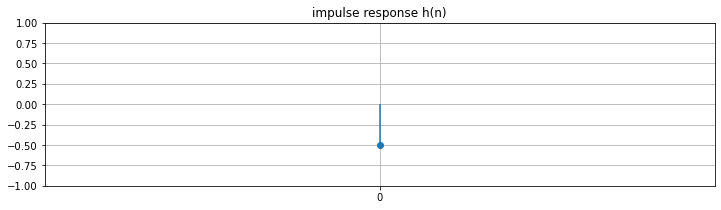

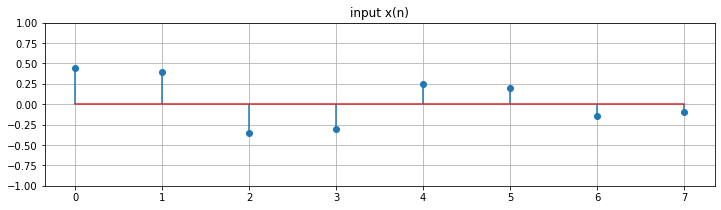

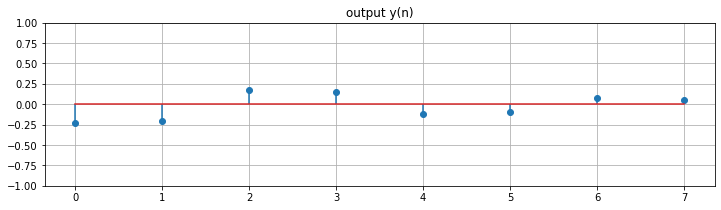

In [4]:
# inpulse response
h = np.zeros(1) 
h[0] = -0.5

# arbitrary input
x = np.array([0.45, 0.40, -0.35, -0.3, 0.25, 0.2, -0.15, -0.10])

# computing output via convolution
y = scipy.signal.convolve(x,h)

myPlot(h, 'impulse response h(n)')
myPlot(x, 'input x(n)')
myPlot(y, 'output y(n)')

### Experiment 2

Delaying the impulse

*Fact*: the lenght (or size) of the convolution is the sum of the lenghts of input and impulse response minus 1

lenght of x(n) 8 lenght of h(n) 10
expected lenght of y(n) is 17 vs actual size of y(n) 17


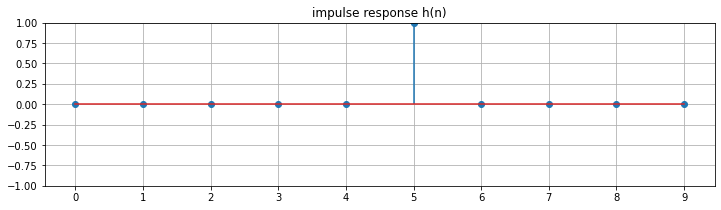

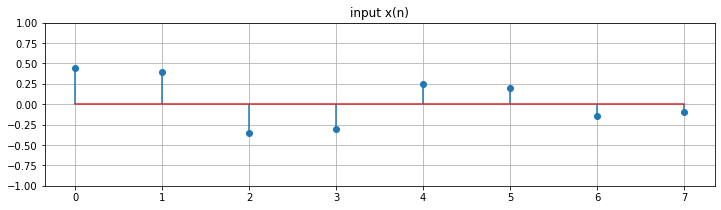

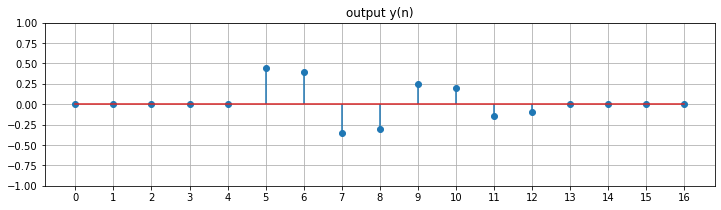

In [5]:
# inpulse response
h = np.zeros(10) 
h[5] = 1

# arbitrary input
x = np.array([0.45, 0.40, -0.35,-0.3, 0.25, 0.2, -0.15, -0.10])

# computing output via convolution
y = scipy.signal.convolve(x,h)

print('lenght of x(n)',x.size,'lenght of h(n)',h.size)
print('expected lenght of y(n) is',x.size + h.size - 1,'vs actual size of y(n)',y.size)

myPlot(h, 'impulse response h(n)')
myPlot(x, 'input x(n)')
myPlot(y, 'output y(n)')



### Experiment 3

Impulse reponse with multiple impulses

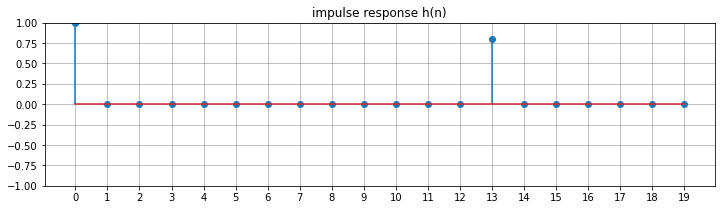

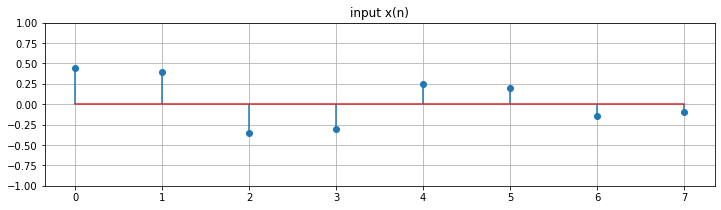

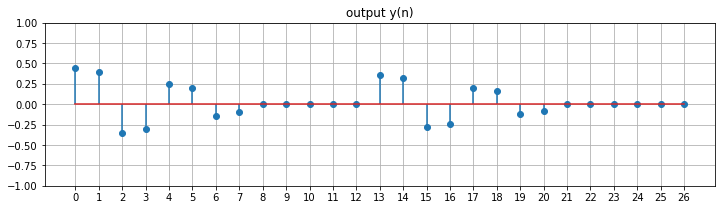

In [6]:
# inpulse response
h = np.zeros(20) 
h[0] = 1
h[13] = 0.8

# arbitrary input
x = np.array([0.45, 0.40, -0.35, -0.3, 0.25, 0.2, -0.15, -0.10])

# computing output via convolution
y = scipy.signal.convolve(x,h)

myPlot(h, 'impulse response h(n)')
myPlot(x, 'input x(n)')
myPlot(y, 'output y(n)')

### Experiment 4

Trying with audio (lenght of signals is significantly longer)

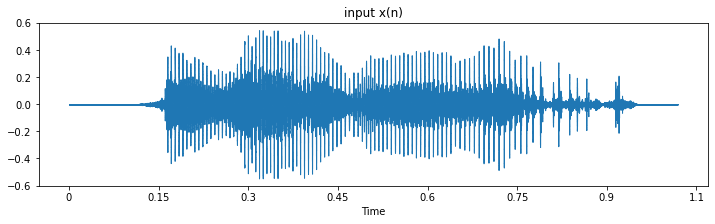

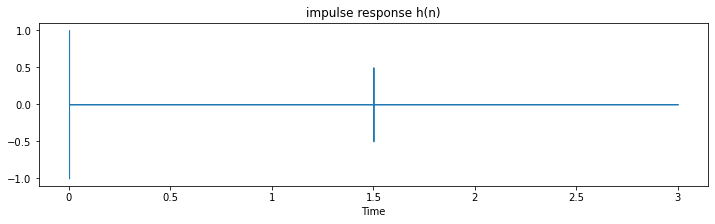

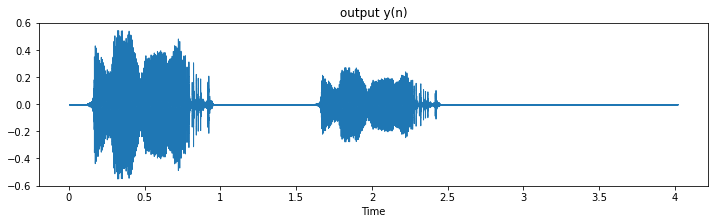

In [7]:
sr = 48000
x, sr = librosa.load('./files/HelloWorld.wav', sr=sr) 
myWaveform(x, sr, 'input x(n)')

h = np.zeros(3*sr) 
h[0] = 1
h[int(1.5*sr)] = 0.5
#for i in range(0,h.size):
#    if i % 6000 == 0:
#        h[i] = (h.size-i)/h.size
    

myWaveform(h, sr, 'impulse response h(n)')

y = scipy.signal.convolve(x,h)

myWaveform(y, sr, 'output y(n)')


In [8]:
sd.play(x,sr)
sd.wait()
sd.play(h,sr)
sd.wait()
sd.play(y,sr)
sd.wait()


### Experiment 5

Convolution with the recording of an acoustic impulse response

In [9]:
from IPython.display import HTML

HTML('<iframe width="800" height="600" src="https://www.youtube.com/embed/Xsx4VBEKciA" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/Users/stefanof/opt/anaconda3/lib/python3.9/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


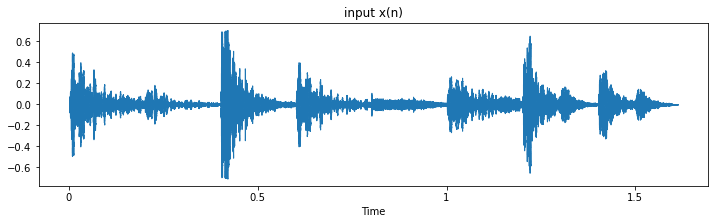

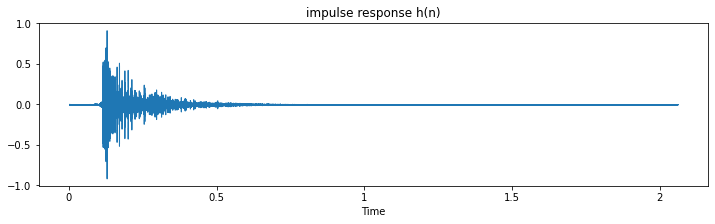

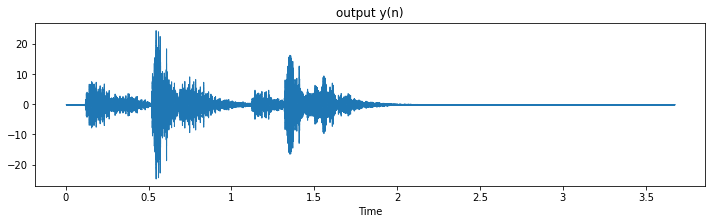

In [10]:
sr = 48000
x, sr = librosa.load('./files/Loop.wav', sr=sr) 
myWaveform(x, sr, 'input x(n)')


h, sr = librosa.load('Files/IR_small_church.wav', sr=sr)    
#h, sr = librosa.load('Files/IR_flanger_space.wav', sr) 
#h, sr = librosa.load('Files/IR_damped_cave.wav', sr)
myWaveform(h, sr, 'impulse response h(n)')

y = scipy.signal.convolve(x,h)
myWaveform(y, sr, 'output y(n)')

In [11]:
sd.play(x,sr)
sd.wait()
sd.play(h,sr)
sd.wait()
sd.play(y,sr)
sd.wait()


### Experiment 6
working with pure tones and observing their responses 

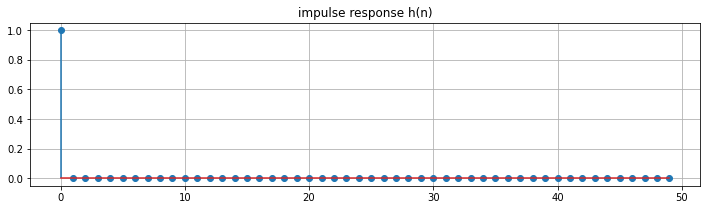

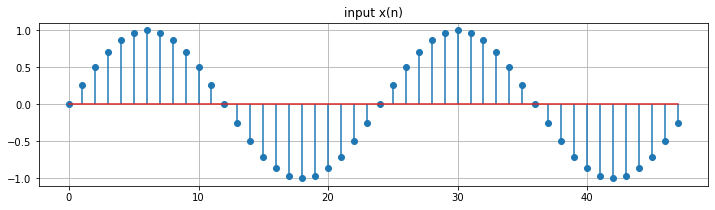

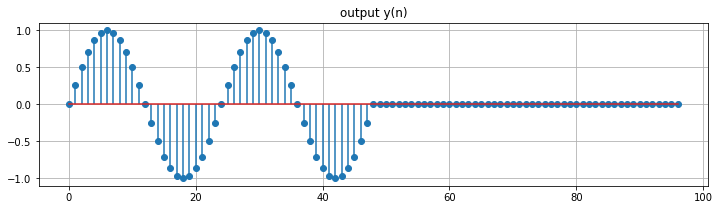

In [12]:
# inpulse response
h = np.zeros(50) 
h[0] = 1
#h[12] = 1

# arbitrary input
x = mySineSynth(2000,1)

# computing output via convolution
y = scipy.signal.convolve(x,h)

myPlot2(h, 'impulse response h(n)')
myPlot2(x, 'input x(n)')
myPlot2(y, 'output y(n)')

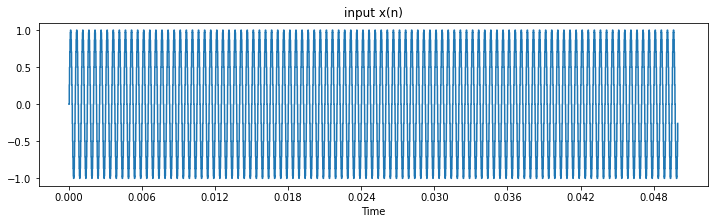

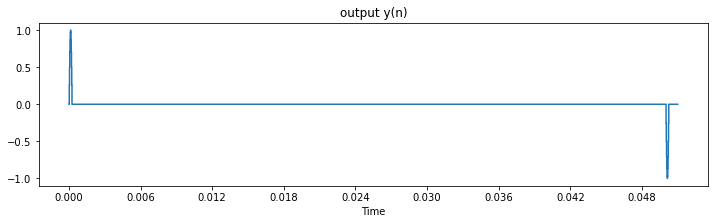

/var/folders/by/m4c7_99d74j70dpnkg3np2r80000gq/T/ipykernel_21595/1159751454.py:85: RuntimeWarning: divide by zero encountered in log10
  plt.plot(p, 20 * np.log10(abs(z)), 'b')


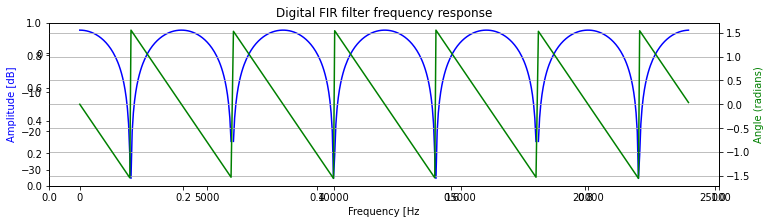

In [13]:
# inpulse response
h = np.zeros(50) 
h[0] = 1
h[12] = 1
h[24] = 0

# arbitrary input
x = mySineSynth(2000,50)

# computing output via convolution
y = scipy.signal.convolve(x,h)

myWaveform(x,sr,'input x(n)')

myWaveform(y,sr,'output y(n)')

myFirResponse(h,sr)

### Experiment 7
designing FIR filters with http://t-filter.engineerjs.com/

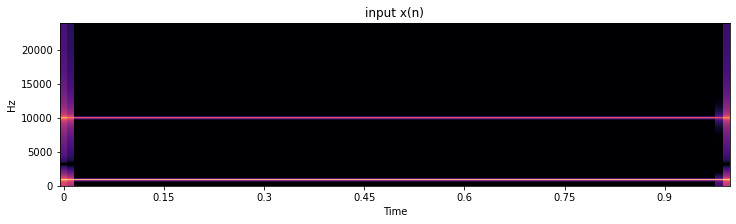

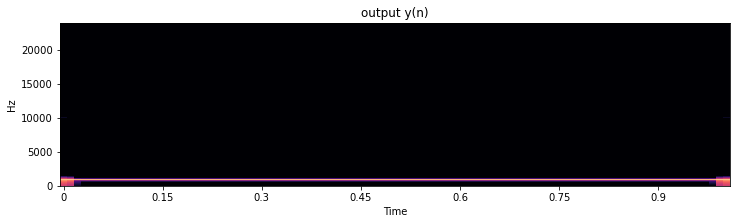

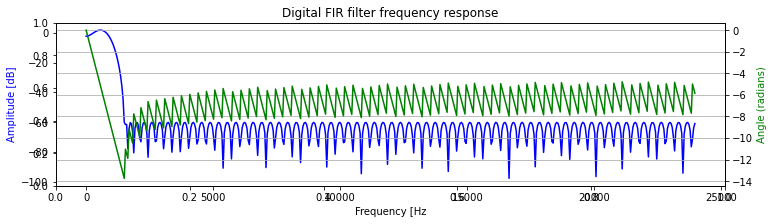

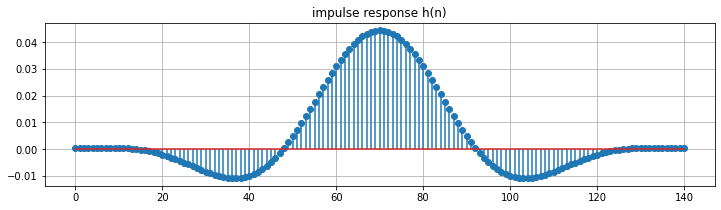

In [14]:
h = np.array([
0.0006221808041488756,
  0.00028894270454767653,
  0.00034629757886828357,
  0.0004031447720575034,
  0.0004570169703737031,
  0.0005050348621890731,
  0.0005439720372092541,
  0.0005702422497921257,
  0.0005800078775637552,
  0.000569173460239569,
  0.0005334687827212263,
  0.0004685682462524707,
  0.00037022508677378305,
  0.00023439856409286178,
  0.00005726303482398194,
  -0.00016442964250060294,
  -0.00043366046979723187,
  -0.000752351993760081,
  -0.0011219400773964298,
  -0.001542595917299643,
  -0.0020135669963603836,
  -0.002532999701748181,
  -0.0030977380512619856,
  -0.0037031521907011926,
  -0.004343384536455574,
  -0.005011105435315143,
  -0.005697656903638683,
  -0.006393062338933975,
  -0.0070859895434657256,
  -0.007763874700433635,
  -0.008413204727937069,
  -0.009019716211248955,
  -0.009568219557576526,
  -0.010043110853036392,
  -0.010428818257556722,
  -0.0107096700767136,
  -0.010870010796820031,
  -0.010895690796178633,
  -0.010772465185021285,
  -0.010488083569404021,
  -0.010031354117957041,
  -0.009393140106932648,
  -0.008566292558014367,
  -0.007545982845176188,
  -0.00632988665678839,
  -0.004918381668809696,
  -0.0033146875873244688,
  -0.0015249308870539673,
  0.00044182222979244703,
  0.002573641142865075,
  0.004855606996274294,
  0.007270578925820993,
  0.00979721044851305,
  0.012415154826822539,
  0.015097300929186227,
  0.0178186107933261,
  0.020551523767944564,
  0.023266428492091578,
  0.025933618785869854,
  0.028523760813644123,
  0.031007546449056532,
  0.03335604761952215,
  0.0355413893792669,
  0.037537402130660445,
  0.0393200269184032,
  0.04086757457644044,
  0.04216101319138014,
  0.04318413447172428,
  0.043924217609847806,
  0.04437195189028101,
  0.044521829514183826,
  0.04437195189028101,
  0.043924217609847806,
  0.04318413447172428,
  0.04216101319138014,
  0.04086757457644044,
  0.0393200269184032,
  0.037537402130660445,
  0.0355413893792669,
  0.03335604761952215,
  0.031007546449056532,
  0.028523760813644123,
  0.025933618785869854,
  0.023266428492091578,
  0.020551523767944564,
  0.0178186107933261,
  0.015097300929186227,
  0.012415154826822539,
  0.00979721044851305,
  0.007270578925820993,
  0.004855606996274294,
  0.002573641142865075,
  0.00044182222979244703,
  -0.0015249308870539673,
  -0.0033146875873244688,
  -0.004918381668809696,
  -0.00632988665678839,
  -0.007545982845176188,
  -0.008566292558014367,
  -0.009393140106932648,
  -0.010031354117957041,
  -0.010488083569404021,
  -0.010772465185021285,
  -0.010895690796178633,
  -0.010870010796820031,
  -0.0107096700767136,
  -0.010428818257556722,
  -0.010043110853036392,
  -0.009568219557576526,
  -0.009019716211248955,
  -0.008413204727937069,
  -0.007763874700433635,
  -0.0070859895434657256,
  -0.006393062338933975,
  -0.005697656903638683,
  -0.005011105435315143,
  -0.004343384536455574,
  -0.0037031521907011926,
  -0.0030977380512619856,
  -0.002532999701748181,
  -0.0020135669963603836,
  -0.001542595917299643,
  -0.0011219400773964298,
  -0.000752351993760081,
  -0.00043366046979723187,
  -0.00016442964250060294,
  0.00005726303482398194,
  0.00023439856409286178,
  0.00037022508677378305,
  0.0004685682462524707,
  0.0005334687827212263,
  0.000569173460239569,
  0.0005800078775637552,
  0.0005702422497921257,
  0.0005439720372092541,
  0.0005050348621890731,
  0.0004570169703737031,
  0.0004031447720575034,
  0.00034629757886828357,
  0.00028894270454767653,
  0.0006221808041488756
 ])

sr = 48000
    
x = 0.3*mySineSynth(880,1000)+0.3*mySineSynth(10000,1000)

y = scipy.signal.convolve(x,h)

#myWaveform(x,sr,'input x(n)')
mySpectrogram(x, sr, 'input x(n)')

#myWaveform(y,sr,'input y(n)')
mySpectrogram(y, sr, 'output y(n)')

myFirResponse(h, sr)

myPlot2(h, 'impulse response h(n)')


In [15]:
sd.play(x,sr)
sd.wait()
sd.play(h,sr)
sd.wait()
sd.play(y,sr)
sd.wait()

/var/folders/by/m4c7_99d74j70dpnkg3np2r80000gq/T/ipykernel_21595/2113342839.py:2: FutureWarning: Pass sr=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x, sr = librosa.load('./files/Loop.wav', sr)


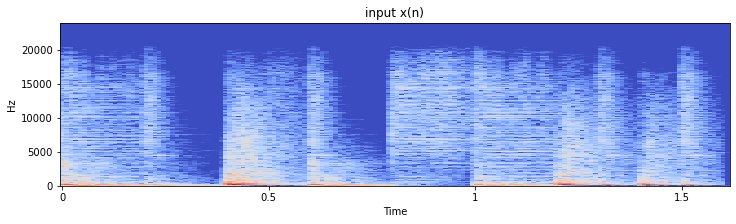

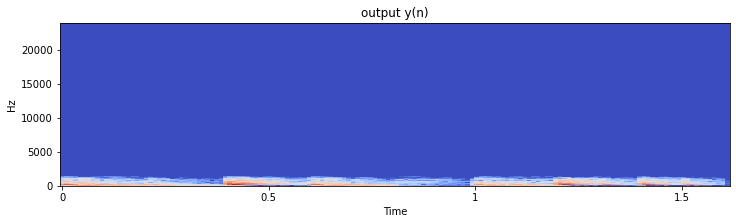

In [16]:
sr = 48000
x, sr = librosa.load('./files/Loop.wav', sr) 

y = scipy.signal.convolve(x,h)

#myWaveform(x,sr,'input x(n)')
mySpectrogram(x, sr, 'input x(n)')

#myWaveform(y,sr,'input y(n)')
mySpectrogram(y, sr, 'output y(n)')

In [17]:
sd.play(x,sr)
sd.wait()
sd.play(h,sr)
sd.wait()
sd.play(y,sr)
sd.wait()

### Experiment 8
Self convolutiom

In [18]:
sr = 48000
x, sr = librosa.load('Files/HelloWorld.wav', sr=sr) 
#x, sr = librosa.load('Files/Loop.wav', sr) 

y = scipy.signal.convolve(x,x)
#y = scipy.signal.convolve(y,x)
#y = scipy.signal.convolve(y,x)
#y = scipy.signal.convolve(x,np.flip(x))
y = y / y.max() #normalize level to 1

sd.play(y,sr)
sd.wait()

#### Task 1

If you have an audio editor or DAW on your computer, where you can apply audio effect to audio signals/files, use the file 1-sample-impulse-48khz.wav as the input/dry signal of an arbitrary processing chain (possibly linear and time invariant), and capture the output/wet signal into a wave file (i.e. the impulse response, use stereo if you apply a stereophonic effect).

Otherwise get an impulse response file from online repositiories such as [freesounds](https://freesound.org/search/?q=impulse+response).

Import the impulse response in python, display the response (using myFirResponse()), compute the convolution with an arbitrary file (e.g. HelloWorld.wav), display the signals (input and output waveform and spectrogram) and listen to them. Try to reconcile what you see/hear with the overall process and comment on expected/unexpected outcomes.

Consider also experiments with less conventional impulse responses, such as [irregular sequence of hand claps in reverberant spaces](https://freesound.org/people/dundass/sounds/509832/) or a [ball bouncing](https://freesound.org/people/Juan_Merie_Venter/sounds/327687/).

## 2. Demistyfying Correlation

The correlation *Rxy(l)* between two time discrete signals *x(n)* and *y(n)* is a measureof their similarity as a function of *l* which is a variable time lag between the two signals (i.e. the relative time shift between them). 

The discrete correlation (for time discrete signals, such as digital audio) is defined as ![Corr Formula](https://img.brainkart.com/imagebk14/EWMvhe1.jpg)

There are many applications for the correlation, such as identification of signals (or patterns) buried in noise, system identification (i.e. find the *h(n)* of an unknown  LTI FIR, etc).

When computed on a signal itself we call it cross correlation *Rxx(l)*, which usually has a maximum for *l=0* (there may be other max values for different values of l). Crosscorrelation  can be used, for instance, to find signal periodicity (or tempo  - for tempo better but more complex approaches have  been proposed).


lenght of x(n) 8 lenght of y(n) 8
expected lenght of Rxy(l) is 15 vs actual size of y(n) 15


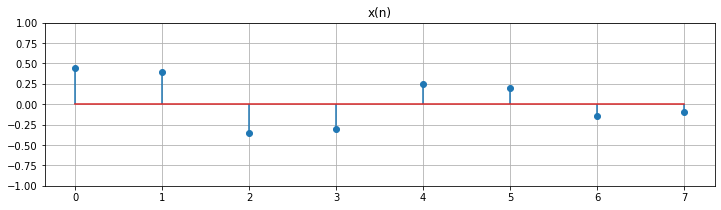

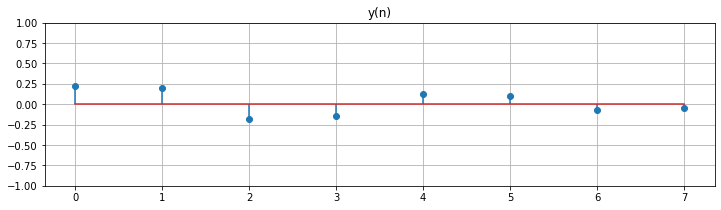

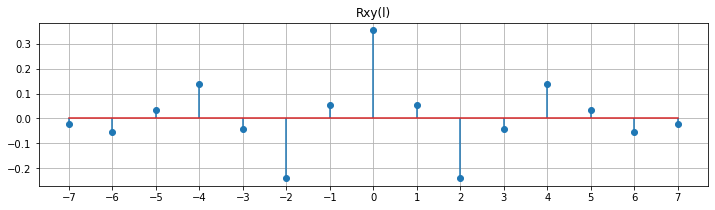

In [19]:
#correlation between signals

# signals
x = np.array([0.45, 0.40, -0.35, -0.3, 0.25, 0.2, -0.15, -0.10])
y = np.array([0.225, 0.20, -0.175, -0.15, 0.125, 0.1, -0.075, -0.05])
#y = np.array([-0.45, -0.40, 0.35, 0.3, -0.25, -0.2, 0.15, 0.10])
#y = np.array([0, 0, 0.45, 0.40, -0.35, -0.3, 0.25, 0.2, -0.15, -0.10])
#y = np.array([0.45, 0.40, -0.35, -0.3, 0.25, 0.2, -0.15, -0.10])


# computing correlation
r = scipy.signal.correlate(y,x,'full')

print('lenght of x(n)',x.size,'lenght of y(n)',y.size)
print('expected lenght of Rxy(l) is',x.size + y.size - 1,'vs actual size of y(n)',r.size)

myPlot(x, 'x(n)')
myPlot(y, 'y(n)')
myPlotCorr(r,x.size,y.size,'Rxy(l)')

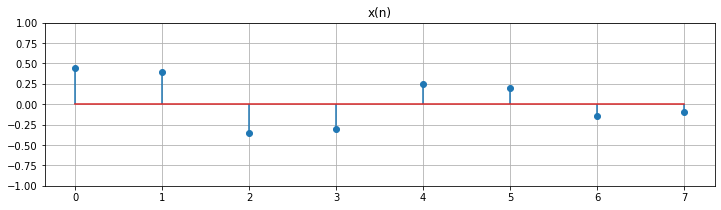

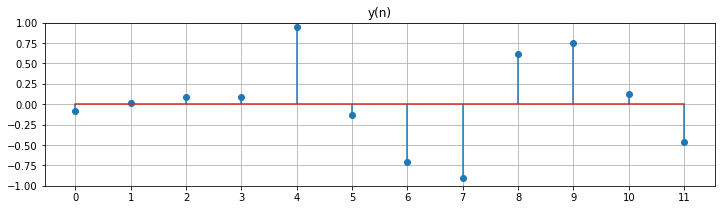

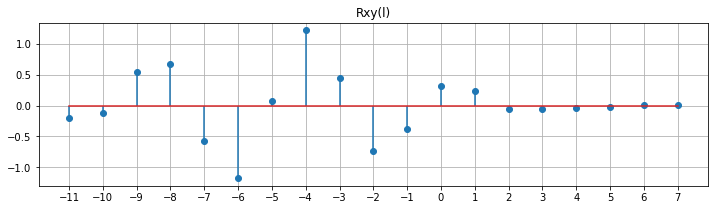

In [20]:
#finding signal buried in noise  via  correlation

# signal
x = np.array([0.45, 0.40, -0.35, -0.3, 0.25, 0.2, -0.15, -0.10])

# same signal  delayed and buried in noise
y = np.array([0, 0, 0, 0, 0.45, 0.40, -0.35, -0.3, 0.25, 0.2, -0.15, -0.10])
y = y + 0.4*np.random.randn(y.size)

# computing correlation
r = scipy.signal.correlate(x,y,'full')

myPlot(x, 'x(n)')
myPlot(y, 'y(n)')
myPlotCorr(r,x.size,y.size,'Rxy(l)')

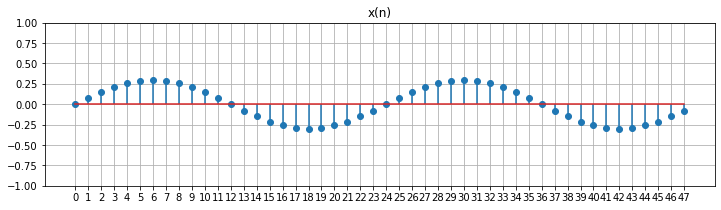

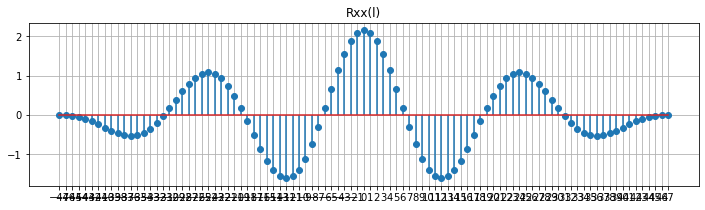

In [21]:
#%matplotlib notebook

# periodic signal
x = 0.3*mySineSynth(2000,1)
#x = x  + 0.2*np.random.randn(x.size) #adding noise

# computing autocorrelation
r = scipy.signal.correlate(x,x,'full')

myPlot(x, 'x(n)')
myPlotCorr(r,x.size,x.size,'Rxx(l)')

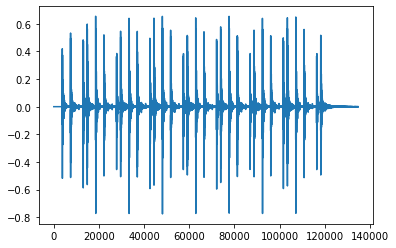

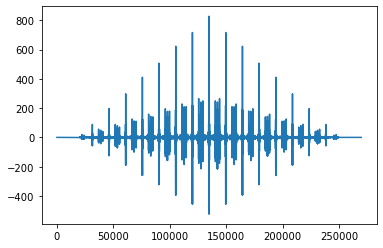

In [22]:
# periodic signal
x, sr = librosa.load('./files/Drums.wav', sr=8000) 

# computing autocorrelation
r = scipy.signal.correlate(x,x,'full')

plt.plot(x)
plt.show()
plt.plot(r)
plt.show()

In [23]:
#sd.play(x,sr)
#sd.wait()


#### Task 2

Work in pairs, and try to estimate the tempo of any short audio file (e.g. /files/Drums.wav) visually inspecting the plot of the autocorrelation (use the "notebook" backend as you may want/need to zoom in).

The autocorrelation was one of the first method used in the past to estimate the "tempo" (e.g. BPM) of audio signals. However, besides being computationally expensive, it presents several limitations (i.e. not accurate in a variety of cases). Over the years plenty of improverd mathods have been proposed (e.g. those in the [Essentia package](https://essentia.upf.edu/tutorial_rhythm_beatdetection.html)).